In [1]:
import numpy as np
import tensorflow as tf
import vgg16
import matplotlib.pyplot as plt
import cv2
plt.rcParams['figure.figsize'] = [12,8]

In [ ]:
sess = tf.Session()

opt_img = tf.Variable( tf.truncated_normal( [1,224,224,3],
                                        dtype=tf.float32,
                                        stddev=1e-1), name='opt_img' )

tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )

vgg = vgg16.vgg16( tmp_img, 'vgg16_weights.npz', sess )

style_img = cv2.imread( 'style.png' )
style_img = cv2.resize( style_img, (224, 224) )
style_img = np.reshape( style_img, [1,224,224,3] )

content_img = cv2.imread( 'content.png' )
content_img = cv2.resize( content_img, (224, 224) )
content_img = np.reshape( content_img, [1,224,224,3] )

layers = [ 'conv1_1', 'conv1_2',
           'conv2_1', 'conv2_2',
           'conv3_1', 'conv3_2', 'conv3_3',
           'conv4_1', 'conv4_2', 'conv4_3',
           'conv5_1', 'conv5_2', 'conv5_3' ]

ops = [ getattr( vgg, x ) for x in layers ]

content_acts = sess.run( ops, feed_dict={vgg.imgs: content_img } )
style_acts = sess.run( ops, feed_dict={vgg.imgs: style_img} )

# content loss
content_P = tf.constant(content_acts[-5])
content_loss = .5*tf.reduce_sum(tf.square(vgg.conv4_2 - content_P)) # tf.subtract ??

# style loss
style_loss = tf.constant(0.) # 0
w_l = 0.2
for i,layer in zip([0,2,4,7,10],[vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1, vgg.conv5_1]):
    b,x,y,N = style_acts[i].shape
    M = x*y
    s = tf.reshape(tf.constant(style_acts[i]), [M, N])
    c = (tf.reshape(layer, [M, N]))
    style_gram = tf.matmul(tf.transpose(s),s)
    gen_gram = tf.matmul(tf.transpose(c),c)
    diff_square = tf.square(gen_gram - style_gram)
    style_loss += w_l*tf.reduce_sum(diff_square)/(4*(N**2)*(M**2))
    
alpha, beta = 1e-3, 1.
loss = alpha*content_loss + beta*style_loss

# optimize only the opt_img
c = 0.1
train_step = tf.train.AdamOptimizer(learning_rate=c).minimize(loss, var_list=[opt_img])

# this clobbers all VGG variables, but we need it to initialize the
# adam stuff, so we reload all of the weights...
sess.run( tf.global_variables_initializer() )
vgg.load_weights( 'vgg16_weights.npz', sess )

# initialize with the content image
sess.run( opt_img.assign( content_img ))

# optimization loop
mod1 = 50
mod2 = 10
for j in xrange(6000):
    _, x = sess.run([train_step, tmp_img])
    if j % mod2 == 0:
        print "iteration {}".format(j)
    if j == 0 or (j+1) % mod1 == 0:
        y = np.reshape(x, (224,224,3))
        cv2.imwrite("imgs/img_{}.png".format(j+1), y)
        x = np.clip(x, 0, 255)
        sess.run( opt_img.assign( x ))

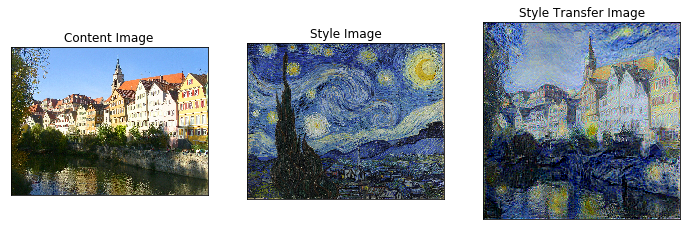

In [2]:
imgs = ["content.png", "style.png", "imgs/img_6000.png"]
titles = ["Content Image", "Style Image", "Style Transfer Image"]
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1,3,i+1)
    plt_img = plt.imread(img)
    plt.imshow(plt_img)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
plt.show()